## Preliminary data analysis metrics

> An explanation of the central idea behind your final project (What is the idea? Why is it interesting? Which datasets did you need to explore the idea? How did you download them?)

Required imports

In [1]:
# clean up outputs from warnings
import warnings
warnings.filterwarnings("ignore")

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import scraper
import utils
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression


from nltk import FreqDist
import pathlib
from multiprocessing import Pool
import pickle
from tqdm import tqdm
import time
import random

plt.rcParams['figure.figsize'] = [10, 8]

If something related to tqdm fails, run:
> `pip install ipywidgets widgetsnbextension pandas-profiling`

Changes?
> `pip freeze > requirements.txt`

## Downloading the data

In [2]:
category_titles = [
    "Category:Wikipedia_level-1_vital_articles",
    "Category:Wikipedia_level-2_vital_articles",
    "Category:Wikipedia_level-3_vital_articles",
    #"Category:Wikipedia_level-4_vital_articles",
    #"Category:Wikipedia_level-5_vital_articles"
]


In [100]:
page_graph, infos  = await scraper.scrape_wiki(category_titles)

A walk-through of your preliminary data analysis, addressing:
> - What is the total size of your data? (MB, number of pages, other variables, etc.)

In [3]:
#infos.keys()

from collections import Counter

#reverts = {k: [edit for edit in v if "comment" in edit and "revert" in edit["comment"].lower()] for k, v in infos["revision_dict"].items()}

def parse_page_revisions(revision_list):
    if len(revision_list) > 2:
        usercounts = dict(Counter([revision["user"] for revision in revision_list if "user" in revision]))

        for i in range(len(revision_list) - 1):
            if "size" in revision_list[i] and "size" in revision_list[i+1]:
                revision_list[i]["diff"] = revision_list[i]["size"] - revision_list[i+1]["size"]
        revision_list[-1]["diff"] = 0

        m = 0
        for i in range(len(revision_list) - 1):
            if "diff" in revision_list[i] and "diff" in revision_list[i+1]:
                diffdiff = revision_list[i]["diff"] + revision_list[i+1]["diff"]
                # detect reverts
                if diffdiff == 0 and revision_list[i]["diff"] != 0:
                    if "user" in revision_list[i] and "user" in revision_list[i+1]:
                        user_orig = revision_list[i+1]["user"]
                        user_revert = revision_list[i]["user"]
                        m_score = min(usercounts[user_orig], usercounts[user_revert])
                        m += m_score
        
        m /= len(revision_list)

        return m
    else:
        return -1

m_scores = {page_title: parse_page_revisions(revision_list) for page_title, revision_list in infos["revision_dict"].items()}
m_scores = dict(sorted(m_scores.items(), key=lambda item: item[1], reverse=True))

print(m_scores)

{'Catholic Church': 14.082572324851865, 'George Washington': 13.444014977654305, 'Solar System': 13.434377495784897, 'Post-classical history': 8.568341944574918, 'Murasaki Shikibu': 8.108188585607941, 'Fascism': 7.788385368126748, 'Anarchism': 7.568471732764183, 'Poland': 7.414779180864569, 'Maya civilization': 6.507437588927694, 'Ecology': 5.522741629816804, 'Joan of Arc': 5.183064825469889, 'Portuguese language': 4.8841318014307396, 'Love': 4.57186723205147, 'Capitalism': 4.36316519014042, 'Turkey': 4.311252421460456, 'The Beatles': 4.212067861715749, 'Sex': 4.049410819496519, 'Abortion': 4.031065525383707, 'Jakarta': 3.9541873963515752, 'Indonesia': 3.9093939187810354, 'Russia': 3.797240338968011, 'Jesus': 3.5101624100775926, 'Philippines': 3.3069467554076537, 'Speed of light': 3.063628020801468, 'Paris': 3.058702935146757, 'Sculpture': 3.039905548996458, 'Alcoholic beverage': 2.884737982914701, 'Israel': 2.863488034807832, 'Algae': 2.780326422584914, 'Economics': 2.730617608409987,

In [4]:
talk_pages = [title for title in page_graph.nodes if title[:5] == "Talk:"]
users = [title for title in page_graph.nodes if title[:5] == "User:"]
print("Number of pages in the vital articles dataset:", len(infos["titles"]))
print("Number of related archived pages:", len(infos["archive_titles"]))
print("Number of users found in relation to the dataset:", len(users))
print("No. nodes", page_graph.number_of_nodes())
print("No. links:", page_graph.number_of_edges())

Number of pages in the vital articles dataset: 1001
Number of related archived pages: 6364
Number of users found in relation to the dataset: 79590
No. nodes 80591
No. links: 178557


> - What is the network you will be analyzing? (number of nodes? number of links?, degree distributions, what are node attributes?, etc.)

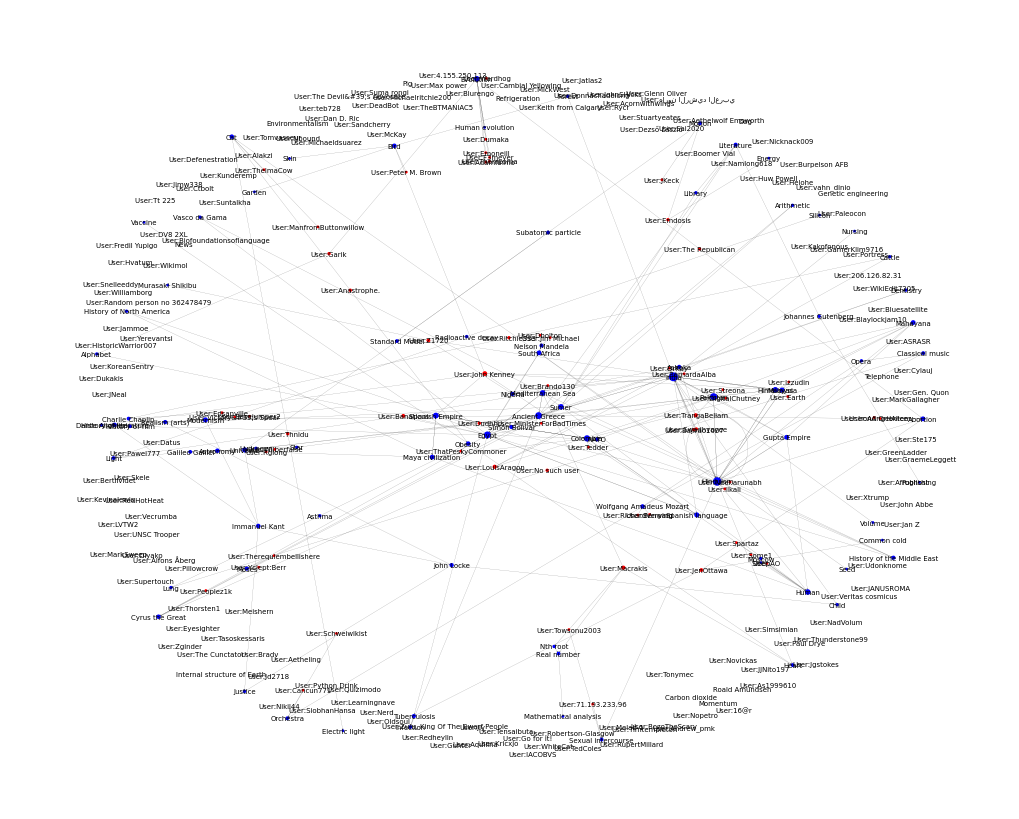

In [8]:
plt.rcParams['font.sans-serif'] = 'DejaVu Sans'

graph = page_graph.copy()

# Only keep users with a high degree
for node in page_graph.nodes(data=True):
    if "page_class" in node[1]:
        if node[1]["page_class"] == "user":
            if page_graph.out_degree(node[0]) <= 1:
                graph.remove_node(node[0])
    else:
        graph.remove_node(node[0])

# Remove outliers
cc = nx.weakly_connected_components(graph)
largest_c = max(cc, key=lambda x: len(x))
rsubgraph = nx.subgraph(graph, largest_c)

#### Randomly filter a couple users and pages
rsubgraph_rnd = rsubgraph.copy()
for node in rsubgraph.nodes(data=True):
    if node[1]["page_class"] == "user":
        if random.uniform(0,1) <= 0.99:
            rsubgraph_rnd.remove_node(node[0])
    else:  # article
        if random.uniform(0,1) <= 0.9:
            rsubgraph_rnd.remove_node(node[0])

rsubgraph = rsubgraph_rnd  # todo remove outliers


# Positions (currently unused)
#pos = nx.nx_agraph.graphviz_layout(rsubgraph, prog="neato")

# Color and size according to coast and degree
color_article = "#0000FF"
color_user = "#FF0000"
node_colors = [color_article if node[1]["page_class"] == "article" else color_user for node in rsubgraph.nodes(data=True)]
node_sizes = [rsubgraph.degree(node) for node in rsubgraph.nodes]

nx.draw(rsubgraph, with_labels=True, font_weight='light', font_size=5, node_size=node_sizes, width=.1, edge_color="#555555", arrowsize=2, node_color=node_colors)

In [ ]:
# sorted(rsubgraph.degree, key=lambda item: item[1], reverse=True)[:10]
import pandas as pd

degrees = pd.DataFrame(rsubgraph.degree, columns=["Node", "Degree"])
degrees.head()

In [ ]:
degrees["PageType"] = ["User" if node[:5] == "User:" else "Talk" for node in degrees.Node ]
users = degrees[degrees.PageType == "User"]
potential_bots = users[users["Node"].str.contains('bot', case=False)]
print(f"{len(potential_bots)} users found with with bot in their name:")
print(",\n".join(potential_bots.Node.values))

After evaluation we found that `User:Botteville`, `User:KP Botany` and `User:NinjaRobotPirate` are human users. Therefore we can filter out the bots by name.


In [ ]:
bot_names = ["User:Community Tech bot", "User:PrimeBOT", "User:InternetArchiveBot", "User:AnomieBOT", "User:RMCD bot", "User:Cyberbot II", "User:CommonsNotificationBot",
"User:LinkBot", "User:FairuseBot", "User:BetacommandBot", "User:Legobot", "User:DumZiBoT"]

human_users = users[~users["Node"].isin(bot_names)]
n = 10
top_n_human_df = human_users.sort_values(["Degree"], ascending=False).head(n)
top_n_human_df

Make subgraph with users and their related pages.



In [ ]:
top_n_human_names = top_n_human_df.Node.values
top_users_graph = graph.subgraph(sum([list(graph.neighbors(node)) + [node] for node in top_n_human_names], []))
pages = [node for node in top_users_graph.nodes if node not in top_n_human_names] 

node_colors = [color_talk if node[1]["page_class"] == "talk" else color_user for node in top_users_graph.nodes(data=True)]
node_sizes = [rsubgraph.degree(node) for node in top_users_graph.nodes]

In [ ]:
degrees = dict(top_users_graph.degree())
sorted_nodes = sorted(degrees, key=degrees.get, reverse=True)
top_nodes_count = 10
top_nodes = [node for node in sorted(degrees, key=degrees.get, reverse=True) if node[:5] == "Talk:"][:top_nodes_count]
labels = {node: node for node in top_nodes}

In [ ]:
from fa2 import ForceAtlas2

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=2.0,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=3.0,
                        strongGravityMode=False,
                        gravity=0.1,

                        # Log
                        verbose=True)
pos=forceatlas2.forceatlas2_networkx_layout(top_users_graph, pos=None, iterations=2000)
    
nx.draw(top_users_graph, pos=pos, node_color=node_colors, node_size=node_sizes, edge_color="#999999", width=0.3, alpha=0.5)
plt.show()

In [ ]:
pos = nx.spring_layout(top_users_graph)
label_pos = {node: (pos[node][0], pos[node][1] + 0.15) for node in top_nodes}
nx.draw(top_users_graph, pos=pos, node_color=node_colors, node_size=node_sizes, edge_color="#999999", width=0.3, alpha=0.5, with_labels=False)
nx.draw_networkx_labels(top_users_graph, pos, labels=labels, font_size=10, font_color='black')
plt.show()

## Basic Analysis

In [ ]:
import pandas as p
import matplotlib.pyplot as plt
import powerlaw
import scipy.stats as sps

# Basic Statistics

count_nodes = len(page_graph)
count_edges = len(page_graph.edges())

# Create degree statistic dicts
degrees = dict(page_graph.degree())
in_degrees = dict(page_graph.in_degree())
out_degrees = dict(page_graph.out_degree())

talk_page_in_degrees = {k: v for k, v in in_degrees.items() if page_graph.nodes[k]["page_class"] == "talk"}
user_out_degrees = {k: v for k, v in out_degrees.items() if page_graph.nodes[k]["page_class"] == "user"}

def find_top(n, stat_dict):
    degrees_pages = []
    degrees_users = []
    top_overall = ""

    for page, degree in dict(sorted(stat_dict.items(), key=lambda item: item[1], reverse=True)).items():
        if top_overall == "":
            top_overall = page + " - " + str(degree)

        # stat dicts don't distinguish between east/west, so we'll do that here
        if len(degrees_pages) < n and page_graph.nodes[page]["page_class"] == "talk": 
            degrees_pages.append(page + " - " + str(degree))
        elif len(degrees_users) < n and page_graph.nodes[page]["page_class"] == "user":
            degrees_users.append(page + " - " + str(degree))

        if len(degrees_pages) >= n and len(degrees_users) >= n:
            break  # found all top v
    
    return degrees_pages, degrees_users, top_overall

degrees_pages, degrees_users, top_overall = find_top(10, degrees)

print("Number of nodes: " + str(count_nodes))
print("Number of links: " + str(count_edges))

print()
print("Highest degrees for pages:")
print("> Overall:")
print(top_overall)
print("> Pages:")
print("\n".join(degrees_pages))
print("> Users:")
print("\n".join(degrees_users))


# Degree multiplicities
in_degrees_counts = p.Series(talk_page_in_degrees.values()).value_counts()
out_degrees_counts = p.Series(user_out_degrees.values()).value_counts()

max_degree = max([max(in_degrees_counts.index), max(out_degrees_counts.index)])
max_multiplicity = max([max(in_degrees_counts.values), max(out_degrees_counts.values)])
range_x = range(1, max_degree + 1)

in_degrees_counts_interp = in_degrees_counts.reindex(range(max_degree+1), fill_value=0).sort_index()
out_degrees_counts_interp = out_degrees_counts.reindex(range(max_degree+1), fill_value=0).sort_index()

# Exponents
fit_in = powerlaw.Fit(in_degrees_counts.sort_index().values, verbose=False)
fit_out = powerlaw.Fit(out_degrees_counts.sort_index().values, verbose=False)

exp_in = fit_in.alpha
exp_out = fit_out.alpha

print("Exponents:")
print("In-degrees: " + str(exp_in) + " sigma: " + str(fit_in.sigma))
print("Out-degrees: " + str(exp_out) + " sigma: " + str(fit_out.sigma))

In [ ]:
import math
def fpl(x, a):
    return x ** (-a)

# Plots
fig, axs = plt.subplots(2, 2)

# Sturges rule
no_bins_sturges = int(1 + math.log(len(talk_page_in_degrees.values()), 2))

axs[0, 0].scatter(in_degrees_counts.index, in_degrees_counts.values, s=5, label='Data')
#hist, bin_edges, _ = axs[0, 0].hist(talk_page_in_degrees.values(), bins=no_bins_sturges, edgecolor='white', label='Data')
#axs[0, 0].set_xticks(bin_edges)
#axs[0, 0].set_xticklabels(['%.0f' % val for val in bin_edges], rotation=45)
axs[0,0].set_title('Multiplicity of In-degrees for Talk pages')
axs[0,0].legend()

axs[0,1].scatter(in_degrees_counts.index, in_degrees_counts.values, s=5, label='Data')
#axs[0,1].plot(range_x, fpl(range_x, exp_in) * count_nodes, 'k-', lw=1, alpha=.75, label='Power Law fit')
axs[0,1].set_yscale('log')
axs[0,1].set_xscale('log')
axs[0,1].set_title('Multiplicity of In-degrees for Talk pages [log-log]')
axs[0,1].set_xlim(1, max_degree)
axs[0,1].set_ylim(1, max_multiplicity)
axs[0,1].legend()

axs[1, 0].scatter(out_degrees_counts.index, out_degrees_counts.values, color="red", s=5, label='Data')
# hist, bin_edges, _ = axs[1, 0].hist(talk_page_in_degrees.values(), bins=no_bins_sturges, color="red", edgecolor='white', label='Data')
# axs[1, 0].set_xticks(bin_edges)
# axs[1, 0].set_xticklabels(['%.0f' % val for val in bin_edges], rotation=45)
axs[1,0].set_title('Multiplicity of Out-degrees for Users')
axs[1,0].legend()

axs[1,1].scatter(out_degrees_counts.index, out_degrees_counts.values, s=5, label='Data', color="red")
#axs[1,1].plot(range_x, fpl(range_x, exp_out) * count_nodes, 'k-', lw=1, alpha=.75, label='Power Law fit')
axs[1,1].set_yscale('log')
axs[1,1].set_xscale('log')
axs[1,1].set_title('Multiplicity of Out-degrees for Users [log-log]')
axs[1,1].set_xlim(1, max_degree)
axs[1,1].set_ylim(1, max_multiplicity)
axs[1,1].legend()

for ax in axs.flat:
    ax.set(xlabel='Degree', ylabel='Multiplicity')

fig.tight_layout()

# Sentiment analysis per user

For this, we will first need to extract all the comments from all pages, as well as the author of the comment
Then we will assign all comment texts to a single author, and run sentiment analysis on the texts.

In [3]:
wikipage_folder = pathlib.Path("./page_contents/")
filenames = list(wikipage_folder.rglob("*.txt"))

#worker_results = [parse_comments_from_pages(filenames[:100])]

with Pool(12) as pool:
    # perform calculations
    worker_results = pool.map(utils.parse_comments_from_pages, utils.chunk_list(filenames, 20))

failed to parse: page_contents/Talk:City.txt
failed to parse: page_contents/Talk:Economy.txt
failed to parse: page_contents/Talk:Sport of athletics.txt
failed to parse: page_contents/Talk:Beijing/Archive 3.txt


KeyboardInterrupt: 

In [ ]:
with open("./parsing_worker_results.pkl", "wb") as file:
    pickle.dump(worker_results, file)

In [4]:
with open("./parsing_worker_results.pkl", "rb") as file:
    worker_results = pickle.load(file)

In [5]:
def append_or_create_list_in_dict(dict, key, value):
    if(key not in dict):
        dict[key] = []
    
    dict[key].append(value)

def append_comment_to_talkpage(page_dict, filepath, comment):
    '''Append a comment to a list of comments on that talk page. Will collect all comments for a specific talk
    page, including comments archived talk pages'''
    filepath_parts = filepath.split('/')

    if(len(filepath_parts) > 2):
        append_or_create_list_in_dict(page_dict, filepath_parts[1], comment)

    else:
        filename_parts = filepath_parts[1].split('.')
        append_or_create_list_in_dict(page_dict,filename_parts[0], comment)

In [6]:
author_dict = {}
list_for_df = []
page_dict = {}

# iterate over the results by the workers
# and transform the output into a dictionary with the users as keys
# and their comments as text
for worker_result in worker_results:
    for filepath, page in worker_result:
        for subsection in page["sections"]:
            if subsection.get("heading"):
                for comments in subsection.get("comments"):
                    if comments.get("author"):
                        for author, comment in utils.parse_comment_subcomment(comments):
                            append_or_create_list_in_dict(author_dict, author, comment)
                            append_comment_to_talkpage(page_dict, filepath, comment)
                            list_for_df.append([author, comment, filepath])

## Analyze sentiment on per-author basis

In [7]:
import utils
# show the top 5 authors written the most text in comment pages
# before tokenizing the comments
items = author_dict.items()
items_sorted = sorted(items, key=lambda x: len(x[1]), reverse=True)
[(author, len(utils.flatten(comments))) for author, comments in items_sorted][:5]

[('Slrubenstein', 2945947),
 (None, 1447914),
 ('The Four Deuces', 1509544),
 ('Rick Norwood', 1548158),
 ('Fowler&amp;fowler', 2809855)]

In [8]:
labMT = pd.read_csv("./labMT.txt", sep="\t")
# to facilitate happiness_average value lookup
labMT.set_index("word", inplace=True)

# Do sentiment analysis
# code taken from assignment 2

def sentiment(tokens):
    if(len(tokens) == 0):
        return
    freq = FreqDist(tokens)

    # filter for the vocabulary we can evaluate with LabMT
    vocab = list(filter(lambda word: word in labMT.index, np.unique(tokens)))

    # array of each token's average happiness weighted by the token's frequency
    weighted_happiness = np.fromiter((freq[word] * labMT.loc[word].happiness_average for word in vocab), dtype=float)
    # each token's frequency
    word_frequencies = np.fromiter((freq[word] for word in vocab), dtype=float)
    return np.sum(weighted_happiness) / np.sum(word_frequencies)

In [9]:
def extract_sentiments(key, text):
    text = [utils.tokenize_custom(s) for s in text]
    text = utils.flatten(text)
    # compute sentiment for individual rapper wiki page
    if len(text) > 100:
        sentiment_value = sentiment(text)
        if(sentiment_value):
            return (key, sentiment_value)

with Pool(12) as pool:
    worker_results = pool.starmap(extract_sentiments, author_dict.items(), 40)
    worker_results = [worker_result for worker_result in worker_results if worker_result is not None]

In [10]:
sentiments = {author: sentiment for author, sentiment in worker_results}
sentiments_df = pd.DataFrame({"Author": sentiments.keys(), "comment_happiness": sentiments.values()})
# use the author's name as index
sentiments_df.set_index("Author", inplace=True)
sentiments_df.head()

,comment_happiness
Author,
William M. Connolley,5.356082
Carchasm,5.391683
Sirdog,5.438778
Scifiphichipsi,5.401500
M.Bitton,5.380814


In [11]:
print("Top 10 authors with the happiest comments:")
best_sentiments = sentiments_df.sort_values("comment_happiness", ascending=False).head(10)
best_sentiments

Top 10 authors with the happiest comments:


,comment_happiness
Author,
2400:1A00:B050:D9DB:10E3:BD5B:F365:EAF9,5.950227
Lia 199712,5.897957
88.107.193.220,5.888372
64.252.198.75,5.884074
2A02:CE0:1801:50E:C51D:9330:A910:98D3,5.879540
Bkusmono,5.855294
76.2.40.115,5.841782
Alex Ramon,5.838727
Krishna mainali777,5.830319


In [12]:
print("Top 10 authors with the saddest comments:")
worst_sentiments = sentiments_df.sort_values("comment_happiness", ascending=True).head(10)
worst_sentiments

Top 10 authors with the saddest comments:


,comment_happiness
Author,
93.229.148.172,4.734500
Cyrillic,4.756739
Pissedpat,4.803218
Nordenfeldt,4.806176
78.2.102.150,4.824016
71.192.41.250,4.825415
2600:4040:A4DB:A600:8059:2428:93E0:3FD6,4.846750
181.63.26.168,4.848586
203.59.112.221,4.857449


In [13]:
# this shows the original comment before tokenizin
[s for s in author_dict.get(best_sentiments.iloc[0].name)]

[" == Movie ==\n \n The 1st Nepali film made in Nepal is Aama.\n The 1st colourful film in the world is Gone with the Wind.\n The 1st actor of Nepali film was Shiva Shankar Mandhar.\n The 1st motion picture made by Nepal film corporation was Paral Ko Ago.\n The 1st Hollywood film to win 11 Oscar awards was Ben Hur.\n The first Nepali Colour movie is Kumari.\n Carvan(Himalayan) is 1st Nepali film made in India.\n Tatum O'Neal was 1st child star to win Oscar for her portrayal of Addie in Paper Moon.\n The 1st Nepali film nominated for the Academy Award was Carvan(Himalayan).\n The 1st Bollywood film to win the Oscar awards was Slam Dog. [[Special:Contributions/2400:1A00:B050:D9DB:10E3:BD5B:F365:EAF9|2400:1A00:B050:D9DB:10E3:BD5B:F365:EAF9]] ([[User talk:2400:1A00:B050:D9DB:10E3:BD5B:F365:EAF9|talk]]) 04:19, 13 November 2022 (UTC)\n"]

In [14]:
[s for s in author_dict.get(worst_sentiments.iloc[0].name)]

[' == Copper Vectoring ==\n \n Im Artikel steht der Satz \'\'\'"Kupfer leitet den elektrischen Strom sehr gut (58 · 106 S/m)."\'\'\' \n <br>Das Kupfernetz der Deutschen Telekom in Deutschland besteht zu 100 Prozent aus Kupfer. Die elektrische Spannung V beträgt zwischen 60-70 Volt. Der elektrische Stromfluss A ist variabel (Elektronik bis 5 Ampere). Die Bundesnetzagentur hat entschieden, dass im Netz der Deutschen Telekom der \'\'\'Bitstrom\'\'\' (Datenpakete) mit 100 MBit/s (300 MBit/s - Leitung/virtuelle Leitung/Leitung-) fließen soll. Dazu investiert die Deutsche Telekom ab 2013 zirka 200 Euro pro Haushalt, bei 24 Millionen Haushalten sind das  4,8 Milliarden Euro. Dabei wird die Kabelverteilertechnik in 330.000 Kabelverteilern in Deutschland durch Technik der Firma [[Alcatel Lucent]] ersetzt. Auf Seiten der Telekomkunden und Mitbewerberkunden werden entsprechende 100 MBit/s-Modems benötigt.  [[Special:Contributions/93.229.148.172|93.229.148.172]] ([[User talk:93.229.148.172|talk]])

### Results from per-author sentiment analysis

What we have seen is that comment sentiment mostly correlates with the topic they are discussing. E.g.: topics discussing the pages fear, Nazi, Hitler have a very low score, but comments discussing e.g. happiness, or the great barrier reef have very high sentiments.

These results show, that it is not beneficial to use the labMT approach to find toxic comments. Different methods should be used for our problem.
To show this also concretely, we will show a statistical correlation between talk page sentiment & article page sentiment.

### Per-talkpage sentiment analysis

In [15]:
def extract_talkpage_sentiments(pagename, text):
    pagename = pagename.replace('Talk:', '')
    text = [utils.tokenize_custom(s) for s in text]
    text = utils.flatten(text)
    # compute sentiment for individual rapper wiki page
    if len(text) > 100:
        sentiment_value = sentiment(text)
        if(sentiment_value):
            return (pagename, sentiment_value)


with Pool(12) as pool:
    worker_results = pool.starmap(extract_talkpage_sentiments, page_dict.items(), 40)
    worker_results = [worker_result for worker_result in worker_results if worker_result is not None]

sentiments_talk_pages = {page: sentiment for page, sentiment in worker_results}

sentiments_pages_df = pd.DataFrame({"pagename": sentiments_talk_pages.keys(), "talkpage_sentiment": sentiments_talk_pages.values()})
# use the author's name as index
# sentiments_pages_df.set_index("pagename", inplace=True)
sentiments_pages_df.head()

,pagename,talkpage_sentiment
0,Plato,5.378497
1,Brazil,5.379409
2,Jerusalem,5.328870
3,Socrates,5.370714
4,American Revolution,5.335119


In [16]:
print("Top 10 happiest talk pages:")
best_sentiments = sentiments_pages_df.sort_values("talkpage_sentiment", ascending=False).head(10)
best_sentiments

Top 10 happiest talk pages:


,pagename,talkpage_sentiment
25,Memory,5.577665
240,Friendship,5.544420
292,Dance,5.541977
126,Drink,5.537447
222,Play (activity),5.534066
675,Festival,5.533009
425,Happiness,5.519176
528,Entertainment,5.518798
221,Heredity,5.516819
696,Garden,5.516650


In [17]:
print("Top 10 saddest talk pages:")
worst_sentiments = sentiments_pages_df.sort_values("talkpage_sentiment", ascending=True).head(10)
worst_sentiments

Top 10 saddest talk pages:


,pagename,talkpage_sentiment
617,Fear,5.188344
660,Terrorism,5.211078
249,War,5.215088
556,Violence,5.219212
622,Nuclear weapon,5.227378
100,Disease,5.228096
380,Weapon,5.230729
457,Tax,5.254547
788,Anger,5.259530
11,Slavery,5.260364


### Per-article-page sentiment analysis results


In [18]:
wikipage_folder = pathlib.Path("./article_pages_plaintext/")
filepaths = list(wikipage_folder.rglob("*.txt"))

# calculate sentiments for article pages
def extract_articlepage_sentiments(filepath):
    pagename = filepath.stem
    with open(filepath, 'r') as file:
        text = file.read()
        return (pagename, sentiment(utils.tokenize_custom(text)))
    
with Pool(12) as pool:
    worker_results = pool.map(extract_articlepage_sentiments, filepaths, 5)
    worker_results = [worker_result for worker_result in worker_results if worker_result is not None]

In [19]:
sentiments_article_pages =  {pagename: sentiment for pagename, sentiment in worker_results}

### Look into potential correlation of article and talk page sentiments

In [20]:
# insert the article page dictionary into the dataframe
sentiments_pages_df["articlepage_sentiment"] = sentiments_pages_df["pagename"].map(sentiments_article_pages)
# check that we didn't get any null values becuase a page didn't have a match
sentiments_pages_df.isnull().values.any()

True

In [21]:
# compute correlation of talk pages and article pages using pearson method 
# see wikipedia which pandas documentetation refers to
#sentiments_pages_df.corr(numeric_only=True)

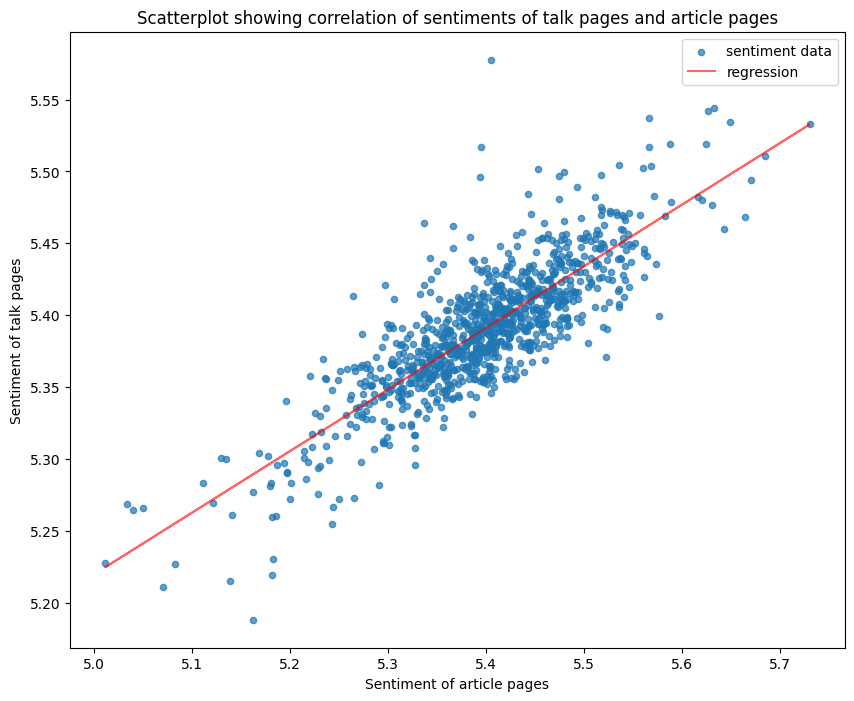

In [25]:
# create graph showing correlation value

fig, ax = plt.subplots()

sentiments_pages_df.plot.scatter (
    "articlepage_sentiment", "talkpage_sentiment", 
    title = "Scatterplot showing correlation of sentiments of talk pages and article pages", 
    xlabel = "Sentiment of article pages",
    ylabel = "Sentiment of talk pages",
    label='sentiment data',
    alpha=0.7,
    ax=ax
)

sentiments_pages_df = sentiments_pages_df.dropna()

X = sentiments_pages_df["articlepage_sentiment"].values.reshape(-1,1)
Y = sentiments_pages_df["talkpage_sentiment"].values.reshape(-1,1)

linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

ax.plot(X, Y_pred, color='red', alpha=0.6, label='regression')
ax.legend()

### Interpretation of correlation results

The results give a correlation coefficient of 0.83. 
This means, the sentiments of article and talk pages are strongly positively correlated (anything over 0.5 is considered strongly correlated). 
Thus, if the sentiment of a article page is higher,
the probability for the talk page to have a higher sentiment is high.

## Toxic comment extraction & analysis

In [ ]:
df_comments = pd.DataFrame(list_for_df, columns = ['Author', 'Comment', 'Filename']) 

In [ ]:
# imports for loading pickles
from nltk.tokenize import word_tokenize
import pandas as pd, numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk

In [ ]:
# Flatten the dictionary values
#flattened_data = [(key, value) for key, values in author_dict.items() for value in values]

# Create a DataFrame from the flattened data
#df = pd.DataFrame(flattened_data, columns=['Author', 'Comment'])

# load the vectorizer
with open('./sentiment-models/vectorizer.pkl', 'rb') as file:
    vec = pickle.load(file)

In [ ]:
# create sparse TF-IDF matrix with vectorizer trained on kaggle toxic comment dataset

comments_sparse = vec.transform(df_comments['Comment'])

In [ ]:
# Classify comments according to the following categories:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

preds = np.zeros((len(df_comments), len(label_cols)))

for i, j in enumerate(label_cols):
    print('predict', j)
    with open(f'./sentiment-models/{j}.pkl', 'rb') as file:
        m,r = pickle.load(file)
    preds[:,i] = m.predict_proba(comments_sparse.multiply(r))[:,1]
    df_comments[j] = preds[:,i]

# this created a matrix where each new column for label_cols contains the probability that a comment is in
# the category with the same title as the column name 

predict toxic
predict severe_toxic
predict obscene
predict threat
predict insult
predict identity_hate


In [ ]:
# get all offensive authors, optionally output all offensive comments
authors = []
for row in df_comments[df_comments["toxic"] > 0.9].iterrows():
    if row[1]["Author"]:
        authors.append(row[1]["Author"])
#     print(row[1]["Filename"], row[1]["Author"], row[1]["toxic"], row[1]["Comment"])

In [ ]:
# how many toxic comments did we find?

len(df_comments[df_comments["toxic"] > 0.9])

198

In [ ]:
seen = set()
multiple_offenders = [x for x in authors if x in seen or seen.add(x)]    

# number of people that have written multiple toxic comments
len(set(multiple_offenders))


19

In [ ]:
# output all toxic comments of multiple offenders
# for row in df_comments[df_comments["toxic"] > 0.9].iterrows():
#     if row[1]["Author"] in multiple_offenders:
#         print(f'{row[1]["Filename"]}, Author: {row[1]["Author"]}, Comment: {" ".join(word_tokenize(row[1]["Comment"]))}')

In [ ]:
df_comments[:10]

,Author,Comment,Filename,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,StrongALPHA,== Criticism; specifically that of Heidegger ...,page_contents/Talk:Plato.txt,0.002984,0.000268,0.002630,0.000147,0.002541,0.000726
1,William M. Connolley,\n : The crit section is kinda a comedy secti...,page_contents/Talk:Plato.txt,0.004758,0.000373,0.002022,0.000119,0.000638,0.000370
2,Carchasm,== Clarification of Sulla's role in ending th...,page_contents/Talk:Plato.txt,0.001216,0.000124,0.000853,0.000091,0.000808,0.000294
3,Williamormous,== Semi-protected edit request on 29 July 202...,page_contents/Talk:Plato.txt,0.003103,0.000303,0.001514,0.000126,0.005934,0.000378
4,Sirdog,:{{done}}<!-- Template:ESp --> —[[User:Sirdog...,page_contents/Talk:Plato.txt,0.003623,0.000411,0.001257,0.000142,0.012909,0.000409
5,Scifiphichipsi,"== Plato's ""Real Name = Aristocles"" ==\n \n T...",page_contents/Talk:Plato.txt,0.001045,0.000134,0.000556,0.000086,0.000363,0.000308
6,Makeshift Sprout,== Semi-protected edit request on 6 November ...,page_contents/Talk:Plato.txt,0.004348,0.000208,0.002488,0.000104,0.002573,0.000391
7,M.Bitton,:[[File:Pictogram voting wait.svg|20px|link=|...,page_contents/Talk:Plato.txt,0.003659,0.000402,0.007512,0.001690,0.008527,0.000572
8,2804:7F3:868E:5BAD:20C0:4F22:D86C:4B0A,"== ""Mixed"" category in racial data ==\n The I...",page_contents/Talk:Brazil.txt,0.005937,0.000264,0.000770,0.000134,0.000496,0.021312
9,Clear Looking Glass,"\n :Yellow or ""Amarela"" does '''''not''''' eq...",page_contents/Talk:Brazil.txt,0.006167,0.000356,0.001256,0.000104,0.002722,0.006491


In [ ]:
# first we need to consolidate pages and archives, so we work with all comments for a specific topic
df_comments_consolidated = df_comments.copy(deep=True)

df_comments_consolidated["Filename"] = df_comments_consolidated["Filename"].map(
    lambda x: x.split("/")[1].replace(".txt", "")
)

# Calculate number of toxic comments per consolidated talk page
count_toxic_per_page = df_comments_consolidated[df_comments_consolidated['toxic'] > 0.9] \
    .groupby('Filename').size() \
    .sort_values(ascending=False)

# Output top 10 pages with most toxic comments
count_toxic_per_page[:10]

Filename
Talk:Anarchism          11
Talk:Adolf Hitler        9
Talk:Socialism           7
Talk:United States       7
Talk:Evolution           6
Talk:Michael Jackson     5
Talk:Abortion            4
Talk:Turkey              4
Talk:Israel              3
Talk:Jesus               3
dtype: int64

In [ ]:
# output toxic pages with highest ratio of toxic comments to all comments
count_total_per_page = df_comments_consolidated.groupby("Filename").size()
(count_toxic_per_page/count_total_per_page).sort_values(ascending=False).fillna(0)[:5]

Filename
Talk:Weather                0.166667
Talk:Hormone                0.019231
Talk:Pre-Columbian era      0.014493
Talk:Scramble for Africa    0.009804
Talk:Snow                   0.007519
dtype: float64

That was not very conclusive. The above basically just outputs short pages that contain 1 toxic comment. Great.


In [ ]:
# lets try again, with outputting pages that contain at least 2 toxic comments.
(count_toxic_per_page.loc[lambda x: x >= 2]/count_total_per_page).sort_values(ascending=False).fillna(0)[:5]

Filename
Talk:Mexico City    0.007273
Talk:Tree           0.004773
Talk:Water          0.004246
Talk:Rumi           0.002911
Talk:Slavery        0.002053
dtype: float64

Seems like results are not much better this time.... For correlation with edit wars, we better use the absolute number of toxic comments.

## Work on analyzing stuff with categories

In [ ]:
pages_to_categories = await scraper.get_wikipedia_article_categories(category_titles)

Parsing talk page batches: 100%|██████████| 100/100 [00:00<00:00, 4519.29it/s]


In [ ]:
categories_to_pages = { page: [] for page in set([value for categories_page in pages_to_categories.values() for value in categories_page])}

for page, categories in pages_to_categories.items():
    for category in categories:
        categories_to_pages[category].append(page)

list_categories_with_most_pages = sorted(categories_to_pages, key = lambda x: len(categories_to_pages[x]), reverse=True)

In [ ]:
# number of distinct categories

len(set([value for categories_page in pages_to_categories.values() for value in categories_page]))

9533